# Part 3 - Data Exploring
---
### Papers Past Topic Modeling

<br/>

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

In [1]:
import sys, gc, subprocess
sys.path.insert(0, '../utils')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 120)
from pyspark.sql import functions as F
from pyspark.sql.types import *
from utils import conf_pyspark, load_dataset
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
plt.style.use('ggplot')
%matplotlib inline
dpi=80

# intiate PySpark
sc, spark = conf_pyspark()

sc

[('spark.app.id', 'local-1548713010885'),
 ('spark.driver.host', 'x99.hub'),
 ('spark.app.name', 'local'),
 ('spark.driver.port', '38565'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.memory', '62g'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.cores', '6'),
 ('spark.driver.maxResultSize', '4g')]


<SparkContext master=local[*] appName=local>

## 1 Load The Clean Dataset

**Load clean dataset:**

In [2]:
df = load_dataset('clean', spark)

In [3]:
n_row = df.count()
print('Shape of dataframe: ({}, {})'.format(n_row, len(df.columns)))
df.sample(False, 0.00001).limit(10).toPandas().head(10)

Shape of dataframe: (15121970, 7)


,id,publisher,region,date,ads,title,content
0,1884439,Bay Of Plenty Times,Bay of Plenty,1878-01-16,False,THE Bay of Plenty Times.,"THE Bay of Plenty Times."" TI!E SPIRIT OF THE IIMES.SHALL.TEAG;) MESPEtD/ 1 '.. KINU JOHH, ACT n*. Wednesday, Januar..."
1,1971717,Inangahua Times,West Coast,1877-03-26,False,TU MUICH LOR.,"TU MUICH LOR.Dxab Mb, Hbditob,— l think what Judge Weston said the other day was true, that the folks here was tn fo..."
2,2059972,Lyttelton Times,Canterbury,1856-04-12,False,AUCKLAND.,"AUCKLAND.Native Outbade.—At the Resident Magistrate's Court, on Monday, March 17, the five natives concerned in the ..."
3,2060167,Bruce Herald,Otago,1872-09-18,False,Untitled,"A Pa¥ioiie.'s Steam Bammeb. — A paviour's rammer, actuated by steam, h^s recently b,een gn^plflye^ ; ift thfc Eiie C..."
4,2065727,Bush Advocate,Hawke's Bay,1891-04-18,False,IV.,"IV.1 met tne inspector soon alter me late cui- [ strike, and had some talk with him thereon. Ho said that he had rec..."
5,2347400,Lyttelton Times,Canterbury,1861-12-18,True,Page 7 Advertisements Column 3,"LAND TO BE LET, with purchasing clause, in the Ashley District, near Sefton.—Apply to Mr. Boys, Rangiora. CHURCH PRO..."
6,2514860,Bush Advocate,Hawke's Bay,1902-08-11,True,Page 4 Advertisements Column 4,"b'THE CENTRAL STORE EOItSEWPO-D. r |^iJs above business 13 now in I going order, and is fully stocked with a(l lines..."
7,2602848,Marlborough Express,Marlborough,1874-03-21,False,THE,"THE"" GIT« me the liberty to know, to utter, ami to argue freely according to conscience, above all other liberties —..."
8,3224076,Ohinemuri Gazette,Waikato,1899-01-28,False,"The Ohinemuri Gazette. AND UPPER THAMES WARDEN SATURDAY, JANUARY 28, 1899. HOMES AND GARDEMNS.","The Ohinemuri Gazette. AND UPPER THAMES WARDEN SATURDAY, JANUARY 28, 1899. HOMES AND GARDEMNS.I Kill a round unvarnm..."
9,3338936,Manawatu Standard,Manawatu-Wanganui,1884-06-06,False,AUSTRALIAN NEWS.,"AUSTRALIAN NEWS.OPENING OF SONTH AUSTRALIAN PARLIAMENT, GOVERNOR'S"" SPEECH. (BY ELECTRIC TELEGRAPH. â COPYRIGHT.) ..."


## 2 Label

**There are only one label - "ads" - that we extracted form raw dataset, check the distribution of "ads":**

In [4]:
n_ads = df.where(F.col('ads') == True).count()
print('ADs number:{0}\nADs proportion:{1}\n'.format(n_ads, 100*n_ads/n_row))

ADs number:4208973
ADs proportion:27.83349656162524



In [5]:
x = ['ADs', 'Total']
value = [n_ads/1000000, n_row/1000000]
x_pos = [i for i, _ in enumerate(x)]

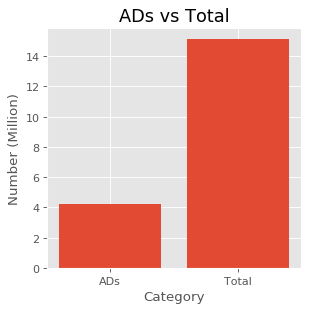

In [6]:
plt.figure(figsize=(4, 4), dpi=dpi)
plt.bar(x_pos, value)
plt.xlabel('Category')
plt.ylabel('Number (Million)')
plt.title("ADs vs Total", fontdict=dict(size=16))
plt.xticks(x_pos, x)
plt.tight_layout()
plt.show()

**In the clean dataset there are:**
* **4,208,973** ADs samples;
* accounting **27.8%** in total.

**The ratio of ADs is neglectable, it is worthwhile to seperately analyze ADs as a subset.**

## Samples

**Each row in the clean dataset is a sample, which may contains one article or a column of articles (advertisements). Here we check the total number of samples over time.**

In [7]:
# transform to pandas dataframe for ploting
df_sample = (df.groupBy('date').count()
             .toPandas()
             .sort_values('date', ascending=True)
             .reset_index(drop=True))

# convert dataframe to time series
df_sample['date'] = pd.to_datetime(df_sample['date'])
df_sample_ts = df_sample.set_index('date')
df_sample_ts.sort_index()
df_sample_ts.T

# Resample the count annually:
df_sample_year = df_sample_ts.resample('AS').sum()
df_sample_year.T

date,1839-01-01 00:00:00,1840-01-01 00:00:00,1841-01-01 00:00:00,1842-01-01 00:00:00,1843-01-01 00:00:00,1844-01-01 00:00:00,1845-01-01 00:00:00,1846-01-01 00:00:00,1847-01-01 00:00:00,1848-01-01 00:00:00,1849-01-01 00:00:00,1850-01-01 00:00:00,1851-01-01 00:00:00,1852-01-01 00:00:00,1853-01-01 00:00:00,1854-01-01 00:00:00,1855-01-01 00:00:00,1856-01-01 00:00:00,1857-01-01 00:00:00,1858-01-01 00:00:00,1859-01-01 00:00:00,1860-01-01 00:00:00,1861-01-01 00:00:00,1862-01-01 00:00:00,1863-01-01 00:00:00,1864-01-01 00:00:00,1865-01-01 00:00:00,1866-01-01 00:00:00,1867-01-01 00:00:00,1868-01-01 00:00:00,1869-01-01 00:00:00,1870-01-01 00:00:00,1871-01-01 00:00:00,1872-01-01 00:00:00,1873-01-01 00:00:00,1874-01-01 00:00:00,1875-01-01 00:00:00,1876-01-01 00:00:00,1877-01-01 00:00:00,1878-01-01 00:00:00,1879-01-01 00:00:00,1880-01-01 00:00:00,1881-01-01 00:00:00,1882-01-01 00:00:00,1883-01-01 00:00:00,1884-01-01 00:00:00,1885-01-01 00:00:00,1886-01-01 00:00:00,1887-01-01 00:00:00,1888-01-01 00:00:00,1889-01-01 00:00:00,1890-01-01 00:00:00,1891-01-01 00:00:00,1892-01-01 00:00:00,1893-01-01 00:00:00,1894-01-01 00:00:00,1895-01-01 00:00:00,1896-01-01 00:00:00,1897-01-01 00:00:00,1898-01-01 00:00:00,1899-01-01 00:00:00,1900-01-01 00:00:00,1901-01-01 00:00:00,1902-01-01 00:00:00,1903-01-01 00:00:00,1904-01-01 00:00:00,1905-01-01 00:00:00,1906-01-01 00:00:00,1907-01-01 00:00:00,1908-01-01 00:00:00,1909-01-01 00:00:00,1910-01-01 00:00:00,1911-01-01 00:00:00,1912-01-01 00:00:00,1913-01-01 00:00:00,1914-01-01 00:00:00,1915-01-01 00:00:00,1916-01-01 00:00:00,1917-01-01 00:00:00,1918-01-01 00:00:00,1919-01-01 00:00:00,1920-01-01 00:00:00,1921-01-01 00:00:00,1922-01-01 00:00:00,1923-01-01 00:00:00,1924-01-01 00:00:00,1925-01-01 00:00:00,1926-01-01 00:00:00,1927-01-01 00:00:00,1928-01-01 00:00:00,1929-01-01 00:00:00,1930-01-01 00:00:00,1931-01-01 00:00:00,1932-01-01 00:00:00,1933-01-01 00:00:00,1934-01-01 00:00:00,1935-01-01 00:00:00,1936-01-01 00:00:00,1937-01-01 00:00:00,1938-01-01 00:00:00,1939-01-01 00:00:00,1940-01-01 00:00:00,1941-01-01 00:00:00,1942-01-01 00:00:00,1943-01-01 00:00:00,1944-01-01 00:00:00,1945-01-01 00:00:00
count,29,747,1037,2489,3489,2210,2492,3422,4190,5022,5336,4969,5731,8041,8031,8102,7815,8532,11719,15059,15214,15445,17076,28014,36448,45372,49273,63893,63821,81265,78578,85094,84895,90802,100077,105399,113054,122377,130769,139368,139927,148203,166116,169761,192133,208329,182576,185250,194431,205712,206945,196746,207771,224375,228491,239197,247319,258627,270294,308069,338352,406056,376973,414214,243256,0,0,0,62413,475261,484781,355177,403550,418485,438281,442804,439826,429576,400251,402660,411685,321095,131751,108407,105133,115436,81973,84628,86485,103010,99195,93456,80485,77882,87058,87056,89497,88276,82076,80569,88503,74958,62700,44900,42815,49276,56781


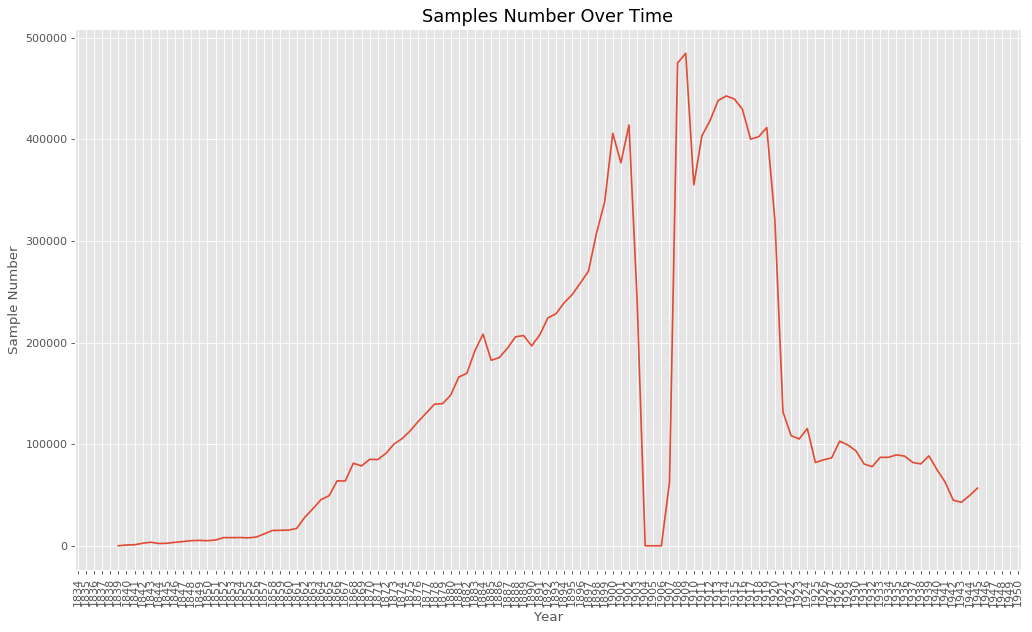

In [8]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=dpi)

year = mdates.YearLocator(month=1)
year_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)

plt.plot_date(df_sample_year.index, df_sample_year['count'], '-')
plt.xlabel('Year')
plt.ylabel('Sample Number')
plt.title("Samples Number Over Time", fontdict=dict(size=16))
plt.xticks(rotation='90')
plt.tight_layout()
plt.show()

## 4 Papers

**Considering each row in the dataset is a sample, each paper consisting multiple samples. Assuming each publisher publishs at most one paper in the same day, we could group publisher and date columns to get the real number of papers of each day.**

In [9]:
path = r'../temp/region.csv'

df_region = spark.createDataFrame(pd.read_csv(path, 
                                  header=None, 
                                  index_col=None, 
                                  names = ['publisher_', 'region'],
                                  encoding='utf8'))

df_paper = (df.groupBy('publisher', 'date').count()
            .join(df_region, df.publisher == df_region.publisher_, how='left')
            .select('publisher', 'region', 'date')
            .toPandas()
            .sort_values('date', ascending=True)
            .reset_index(drop=True))

df_paper.region = df_paper.region.fillna('unknown')

df_paper['date'] = pd.to_datetime(df_paper['date'])

In [10]:
print('Total Sample / Total Paper =', n_row / df_paper.shape[0])
print('Shape of dataframe:', df_paper.shape)
df_paper.sample(5)

Total Sample / Total Paper = 44.430906013844655
Shape of dataframe: (340348, 3)


,publisher,region,date
285571,Wanganui Chronicle,Manawatu-Wanganui,1913-05-02
227581,Manawatu Herald,Manawatu-Wanganui,1900-06-26
191201,Tuapeka Times,Otago,1895-11-16
266365,Poverty Bay Herald,Gisborne,1909-10-09
150159,Thames Star,Waikato,1890-07-26


**From above we see one paper contains 44.4 samples in average.**

### 4.1 Papers Distribution by Publisher

In [11]:
df_paper_count = (df_paper.groupby('publisher').size()
                  .reset_index(name='count')
                  .sort_values('count', ascending=False).reset_index(drop=True))

df_paper_count.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67
publisher,Evening Post,Otago Daily Times,Grey River Argus,Colonist,Wanganui Chronicle,Nelson Evening Mail,Thames Star,West Coast Times,Marlborough Express,Wanganui Herald,Star,Poverty Bay Herald,Hawera & Normanby Star,Taranaki Herald,Auckland Star,Ashburton Guardian,Timaru Herald,North Otago Times,Feilding Star,Southland Times,Hawke's Bay Herald,Bay Of Plenty Times,Daily Southern Cross,Daily Telegraph,Tuapeka Times,Taranaki Daily News,Wairarapa Daily Times,Mataura Ensign,Akaroa Mail and Banks Peninsula Advertiser,Ellesmere Guardian,Wellington Independent,Inangahua Times,Northern Advocate,Bruce Herald,Nelson Examiner and New Zealand Chronicle,Ohinemuri Gazette,Clutha Leader,Otago Witness,Waikato Times,Manawatu Herald,Bush Advocate,Manawatu Standard,"Rodney and Otamatea Times, Waitemata and Kaipara Gazette",Observer,New Zealand Tablet,Manawatu Times,Otautau Standard and Wallace County Chronicle,NZ Truth,Lyttelton Times,New Zealand Spectator and Cook's Strait Guardian,New Zealander,Kaipara and Waitemata Echo,Oxford Observer,Te Aroha News,Waiapu Church Gazette,New Zealand Gazette and Wellington Spectator,Hutt News,New Zealand Free Lance,Waimate Daily Advertiser,New Zealand Colonist and Port Nicholson Advertiser,Hawke's Bay Weekly Times,Kai Tiaki,New Zealand Illustrated Magazine,Progress,Fair Play,New Zealand Advertiser and Bay of Islands Gazette,Albertland Gazette,Waiapu Church Times
count,23556,16518,14667,13558,12339,12238,11953,11869,11739,11587,11437,11364,10676,10226,10035,9514,9068,8894,8611,8473,7943,6616,6093,5165,4662,4647,4277,4210,4063,3980,3900,3763,3720,3614,3161,3028,2965,2825,2142,2045,2039,1866,1782,1704,1703,1505,1285,1200,1007,995,701,500,448,437,411,368,296,286,231,105,90,88,51,35,27,27,11,9


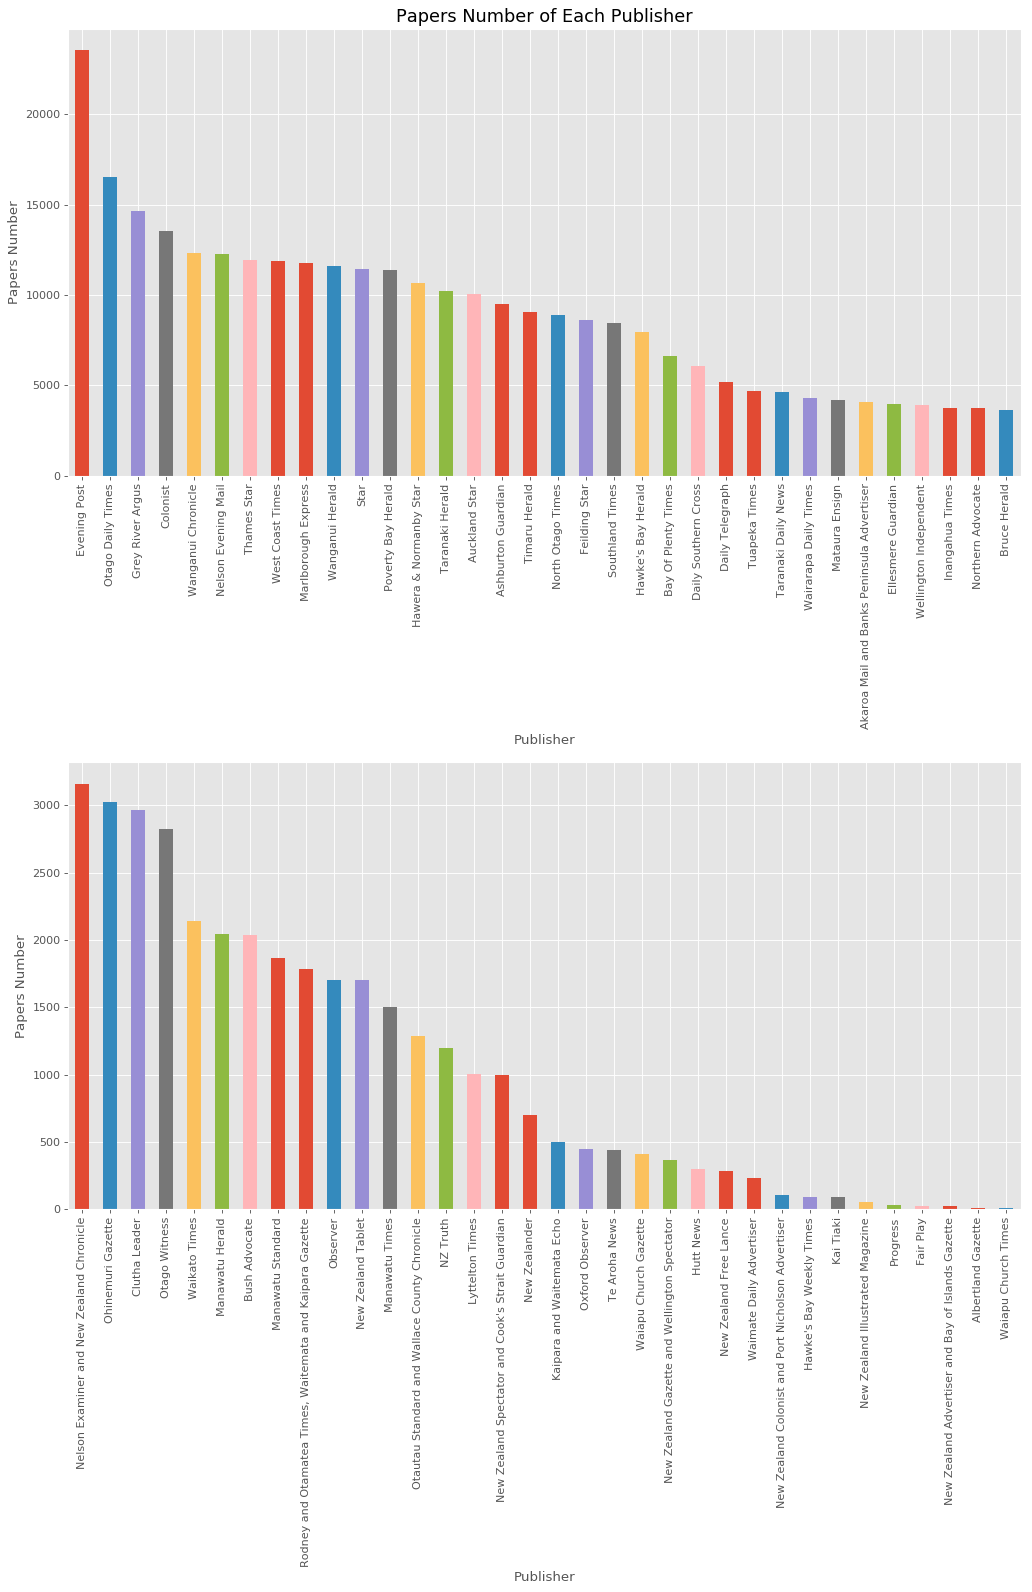

In [12]:
# index of half dataframe, split dataframe to plot better
i = int(df_paper_count.shape[0]/2)

# plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13, 20), dpi=dpi)
fig.subplots_adjust(hspace=0.6)
df_paper_count.iloc[:i].plot(ax=axes[0], 
                             kind='bar', 
                             x='publisher', 
                             y='count', 
                             legend=False)
df_paper_count.iloc[i:].plot(ax=axes[1], 
                             kind='bar', 
                             x='publisher', 
                             y='count', 
                             legend=False)
axes[0].set_title('Papers Number of Each Publisher', fontdict=dict(size=16))
axes[0].set_ylabel('Papers Number')
axes[0].set_xlabel('Publisher')
axes[1].set_ylabel('Papers Number')
axes[1].set_xlabel('Publisher')
fig.tight_layout()
plt.show()

### 4.2 Papers Distribution by Region

In [13]:
df_region_count = (df_paper.groupby('region').size()
                   .reset_index(name='count')
                   .sort_values('count', ascending=False).reset_index(drop=True))

df_region_count.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
region,Otago,Canterbury,Manawatu-Wanganui,Wellington,West Coast,Nelson,Taranaki,Auckland,Waikato,Hawke's Bay,Marlborough,Gisborne,Bay of Plenty,Northland,unknown,National
count,53446,39748,37953,33783,30299,28957,25549,20826,17560,15237,11739,11364,6616,3747,2324,1200


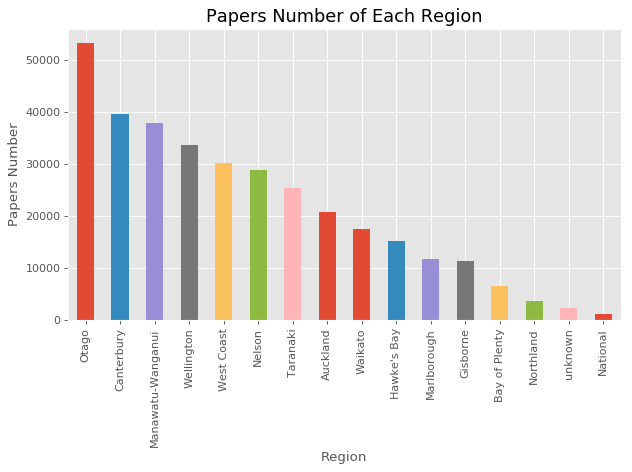

In [14]:
# plot
fig, axes = plt.subplots(figsize=(8, 6), dpi=dpi)
df_region_count.plot(ax=axes, 
                     kind='bar', 
                     x='region', 
                     y='count', 
                     legend=False)
axes.set_title('Papers Number of Each Region', fontdict=dict(size=16))
axes.set_ylabel('Papers Number')
axes.set_xlabel('Region')
axes.set_ylabel('Papers Number')
axes.set_xlabel('Region')
fig.tight_layout()
plt.show()

### 4.3 Papers Distribution Over Time

**Convert dataframe paper dataframe** `df_paper` **time series**:

In [16]:
# convert dataframe to time series
df_paper_ts = (df_paper
               .groupby([df_paper['date']])
               .size()
               .reset_index(name='count')
               .sort_values('date', ascending=True))
df_paper_ts = df_paper_ts.set_index('date')
df_paper_ts.sort_index()

# Resample the count annually
df_paper_year = df_paper_ts.resample('AS').sum()
df_paper_year.T

date,1839-01-01 00:00:00,1840-01-01 00:00:00,1841-01-01 00:00:00,1842-01-01 00:00:00,1843-01-01 00:00:00,1844-01-01 00:00:00,1845-01-01 00:00:00,1846-01-01 00:00:00,1847-01-01 00:00:00,1848-01-01 00:00:00,1849-01-01 00:00:00,1850-01-01 00:00:00,1851-01-01 00:00:00,1852-01-01 00:00:00,1853-01-01 00:00:00,1854-01-01 00:00:00,1855-01-01 00:00:00,1856-01-01 00:00:00,1857-01-01 00:00:00,1858-01-01 00:00:00,1859-01-01 00:00:00,1860-01-01 00:00:00,1861-01-01 00:00:00,1862-01-01 00:00:00,1863-01-01 00:00:00,1864-01-01 00:00:00,1865-01-01 00:00:00,1866-01-01 00:00:00,1867-01-01 00:00:00,1868-01-01 00:00:00,1869-01-01 00:00:00,1870-01-01 00:00:00,1871-01-01 00:00:00,1872-01-01 00:00:00,1873-01-01 00:00:00,1874-01-01 00:00:00,1875-01-01 00:00:00,1876-01-01 00:00:00,1877-01-01 00:00:00,1878-01-01 00:00:00,1879-01-01 00:00:00,1880-01-01 00:00:00,1881-01-01 00:00:00,1882-01-01 00:00:00,1883-01-01 00:00:00,1884-01-01 00:00:00,1885-01-01 00:00:00,1886-01-01 00:00:00,1887-01-01 00:00:00,1888-01-01 00:00:00,1889-01-01 00:00:00,1890-01-01 00:00:00,1891-01-01 00:00:00,1892-01-01 00:00:00,1893-01-01 00:00:00,1894-01-01 00:00:00,1895-01-01 00:00:00,1896-01-01 00:00:00,1897-01-01 00:00:00,1898-01-01 00:00:00,1899-01-01 00:00:00,1900-01-01 00:00:00,1901-01-01 00:00:00,1902-01-01 00:00:00,1903-01-01 00:00:00,1904-01-01 00:00:00,1905-01-01 00:00:00,1906-01-01 00:00:00,1907-01-01 00:00:00,1908-01-01 00:00:00,1909-01-01 00:00:00,1910-01-01 00:00:00,1911-01-01 00:00:00,1912-01-01 00:00:00,1913-01-01 00:00:00,1914-01-01 00:00:00,1915-01-01 00:00:00,1916-01-01 00:00:00,1917-01-01 00:00:00,1918-01-01 00:00:00,1919-01-01 00:00:00,1920-01-01 00:00:00,1921-01-01 00:00:00,1922-01-01 00:00:00,1923-01-01 00:00:00,1924-01-01 00:00:00,1925-01-01 00:00:00,1926-01-01 00:00:00,1927-01-01 00:00:00,1928-01-01 00:00:00,1929-01-01 00:00:00,1930-01-01 00:00:00,1931-01-01 00:00:00,1932-01-01 00:00:00,1933-01-01 00:00:00,1934-01-01 00:00:00,1935-01-01 00:00:00,1936-01-01 00:00:00,1937-01-01 00:00:00,1938-01-01 00:00:00,1939-01-01 00:00:00,1940-01-01 00:00:00,1941-01-01 00:00:00,1942-01-01 00:00:00,1943-01-01 00:00:00,1944-01-01 00:00:00,1945-01-01 00:00:00
count,2,64,69,192,253,166,195,271,366,416,452,451,432,563,521,546,417,418,518,680,684,711,764,1125,1356,1543,1816,2466,2705,3394,3378,3514,3747,3868,4310,4666,4677,4968,5386,5741,5963,6224,7006,6736,7701,7840,7337,7134,7365,7525,7453,7214,7711,8027,7727,7644,7677,7961,7637,7848,7984,8599,7774,7733,5471,0,0,0,916,7049,6798,5074,5395,5483,5340,5605,5397,5323,5175,5261,5277,4475,1398,877,785,786,582,580,597,617,632,628,568,577,519,474,476,448,424,421,470,473,473,462,472,469,470


**Plot annual papers number:**

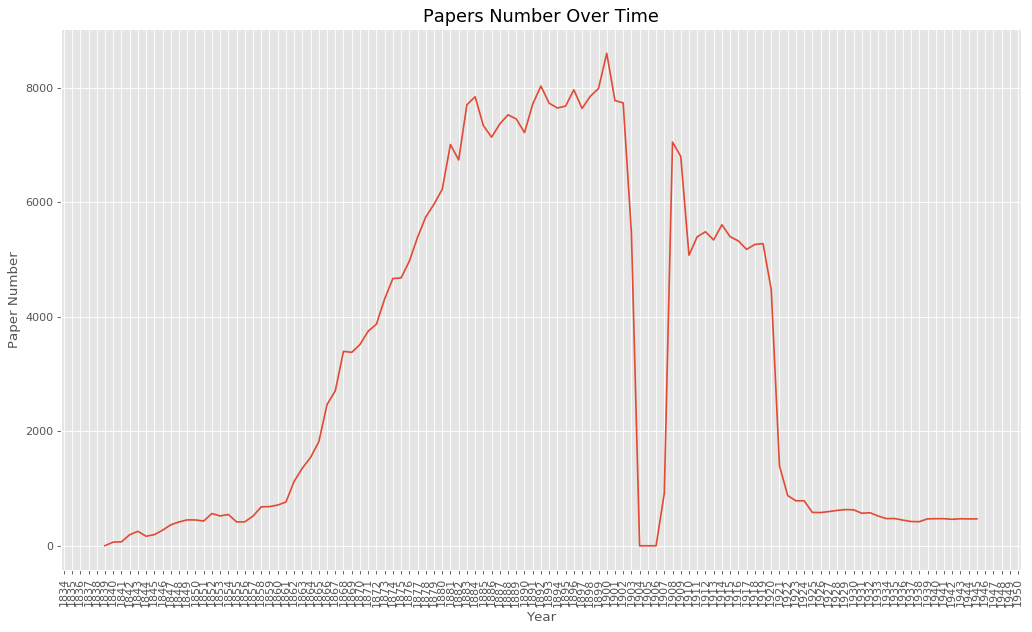

In [17]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=dpi)

year = mdates.YearLocator(month=1)
year_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)

plt.plot_date(df_paper_year.index, df_paper_year['count'], '-')
plt.xlabel('Year')
plt.ylabel('Paper Number')
plt.title("Papers Number Over Time", fontdict=dict(size=16))
plt.xticks(rotation='90')
plt.tight_layout()
plt.show()

### 4.4 Papers Distribution by Region Over Time

In [18]:
# convert dataframe to time series
df_paper_region_ts = (df_paper
                      .groupby([df_paper['date'], df_paper['region']])
                      .size()
                      .reset_index(name='count')
                      .sort_values('date', ascending=True))
df_paper_region_ts = df_paper_region_ts.set_index('date')
df_paper_region_ts.sort_index()
df_paper_region_ts.T

date,1839-08-21 00:00:00,1839-09-06 00:00:00,1840-04-18 00:00:00,1840-04-25 00:00:00,1840-05-02 00:00:00,1840-05-09 00:00:00,1840-05-16 00:00:00,1840-05-23 00:00:00,1840-05-30 00:00:00,1840-06-06 00:00:00,1840-06-13 00:00:00,1840-06-15 00:00:00,1840-06-19 00:00:00,1840-06-20 00:00:00,1840-06-25 00:00:00,1840-06-27 00:00:00,1840-07-02 00:00:00,1840-07-04 00:00:00,1840-07-09 00:00:00,1840-07-11 00:00:00,1840-07-16 00:00:00,1840-07-18 00:00:00,1840-07-23 00:00:00,1840-07-25 00:00:00,1840-07-30 00:00:00,1840-08-01 00:00:00,1840-08-06 00:00:00,1840-08-08 00:00:00,1840-08-13 00:00:00,1840-08-15 00:00:00,1840-08-20 00:00:00,1840-08-22 00:00:00,1840-08-27 00:00:00,1840-08-29 00:00:00,1840-09-03 00:00:00,1840-09-05 00:00:00,1840-09-10 00:00:00,1840-09-12 00:00:00,1840-09-17 00:00:00,1840-09-19 00:00:00,1840-09-24 00:00:00,1840-10-01 00:00:00,1840-10-03 00:00:00,1840-10-08 00:00:00,1840-10-10 00:00:00,1840-10-15 00:00:00,1840-10-17 00:00:00,1840-10-22 00:00:00,1840-10-24 00:00:00,1840-10-29 00:00:00,1840-10-31 00:00:00,1840-11-05 00:00:00,1840-11-07 00:00:00,1840-11-12 00:00:00,1840-11-14 00:00:00,1840-11-19 00:00:00,1840-11-21 00:00:00,1840-11-26 00:00:00,1840-11-28 00:00:00,1840-12-03 00:00:00,...,1945-11-13 00:00:00,1945-11-13 00:00:00,1945-11-14 00:00:00,1945-11-14 00:00:00,1945-11-15 00:00:00,1945-11-16 00:00:00,1945-11-16 00:00:00,1945-11-17 00:00:00,1945-11-19 00:00:00,1945-11-20 00:00:00,1945-11-20 00:00:00,1945-11-21 00:00:00,1945-11-21 00:00:00,1945-11-22 00:00:00,1945-11-23 00:00:00,1945-11-23 00:00:00,1945-11-24 00:00:00,1945-11-26 00:00:00,1945-11-27 00:00:00,1945-11-27 00:00:00,1945-11-28 00:00:00,1945-11-28 00:00:00,1945-11-29 00:00:00,1945-11-30 00:00:00,1945-11-30 00:00:00,1945-12-01 00:00:00,1945-12-01 00:00:00,1945-12-03 00:00:00,1945-12-04 00:00:00,1945-12-04 00:00:00,1945-12-05 00:00:00,1945-12-05 00:00:00,1945-12-06 00:00:00,1945-12-07 00:00:00,1945-12-07 00:00:00,1945-12-08 00:00:00,1945-12-10 00:00:00,1945-12-11 00:00:00,1945-12-11 00:00:00,1945-12-12 00:00:00,1945-12-12 00:00:00,1945-12-13 00:00:00,1945-12-14 00:00:00,1945-12-14 00:00:00,1945-12-15 00:00:00,1945-12-17 00:00:00,1945-12-18 00:00:00,1945-12-18 00:00:00,1945-12-19 00:00:00,1945-12-19 00:00:00,1945-12-20 00:00:00,1945-12-21 00:00:00,1945-12-21 00:00:00,1945-12-22 00:00:00,1945-12-24 00:00:00,1945-12-26 00:00:00,1945-12-27 00:00:00,1945-12-28 00:00:00,1945-12-29 00:00:00,1945-12-31 00:00:00
region,Wellington,Wellington,Wellington,Wellington,Wellington,Wellington,Wellington,Wellington,Wellington,Wellington,Wellington,Northland,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,...,Canterbury,Wellington,Auckland,Wellington,Wellington,Wellington,Canterbury,Wellington,Wellington,Canterbury,Wellington,Auckland,Wellington,Wellington,Canterbury,Wellington,Wellington,Wellington,Wellington,Canterbury,Auckland,Wellington,Wellington,Canterbury,Wellington,Wellington,unknown,Wellington,Canterbury,Wellington,Wellington,Auckland,Wellington,Canterbury,Wellington,Wellington,Wellington,Canterbury,Wellington,Auckland,Wellington,Wellington,Wellington,Canterbury,Wellington,Wellington,Canterbury,Wellington,Auckland,Wellington,Wellington,Canterbury,Wellington,Wellington,Wellington,Wellington,Wellington,Wellington,Wellington,Wellington
count,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [19]:
# time series dataframe by regions
df_paper_region_year = (df_paper_region_ts
                        .groupby('region')['count']
                        .resample('AS').sum()
                        .unstack('region').fillna(0))

df_paper_region_year.sample(5)

region,Auckland,Bay of Plenty,Canterbury,Gisborne,Hawke's Bay,Manawatu-Wanganui,Marlborough,National,Nelson,Northland,Otago,Taranaki,Waikato,Wellington,West Coast,unknown
date,,,,,,,,,,,,,,,,
1854-01-01,103.0,0.0,75.0,0.0,0.0,0.0,0.0,0.0,76.0,0.0,40.0,52.0,0.0,200.0,0.0,0.0
1870-01-01,528.0,0.0,410.0,0.0,99.0,294.0,0.0,0.0,487.0,0.0,679.0,105.0,0.0,466.0,446.0,0.0
1922-01-01,42.0,0.0,103.0,0.0,0.0,0.0,0.0,52.0,0.0,0.0,51.0,305.0,0.0,308.0,0.0,16.0
1941-01-01,51.0,0.0,101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,309.0,0.0,12.0
1876-01-01,613.0,81.0,611.0,0.0,0.0,612.0,104.0,0.0,468.0,0.0,1241.0,104.0,156.0,307.0,619.0,52.0


**Plot all regions:**

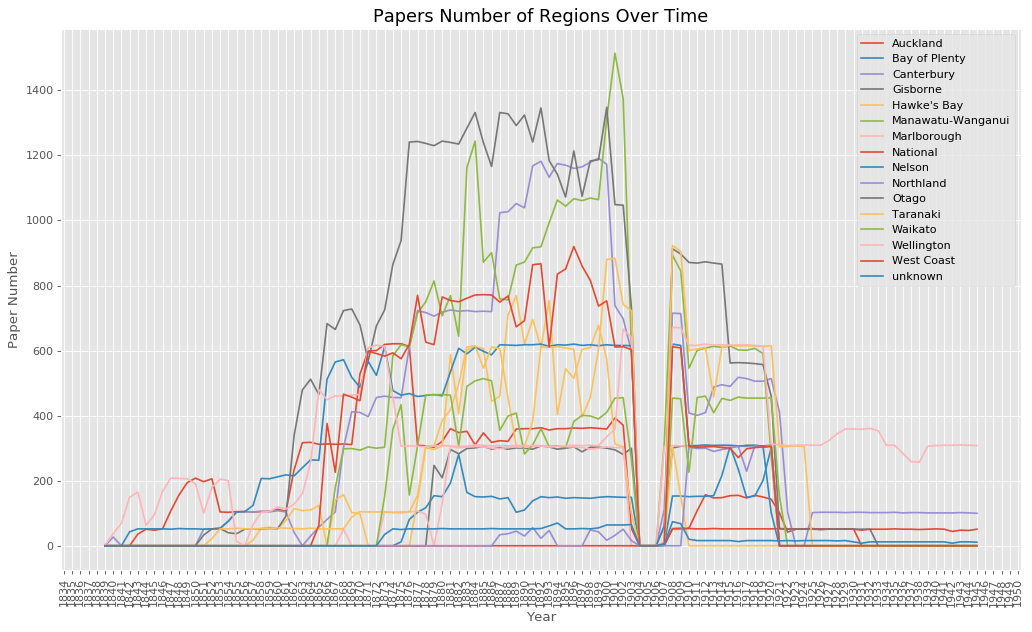

In [20]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=dpi)

year = mdates.YearLocator(month=1)
year_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)

for i, c in enumerate(df_paper_region_year.columns):
    plt.plot_date(df_paper_region_year.index, df_paper_region_year[df_paper_region_year.columns[i]], '-')
    
plt.xlabel('Year')
plt.ylabel('Paper Number')
plt.xticks(rotation='90')
plt.title("Papers Number of Regions Over Time", fontdict=dict(size=16))
ax.legend()
plt.tight_layout()
plt.show()

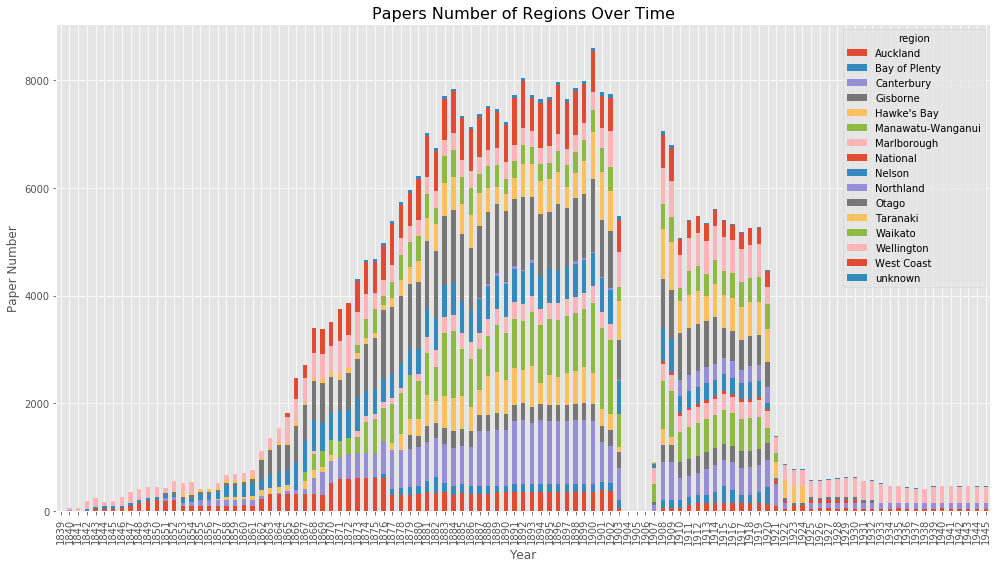

In [21]:
# convert date to year format string
df_paper_region_year_bar = df_paper_region_year.copy(deep=True)
df_paper_region_year_bar.index = df_paper_region_year_bar.index.strftime('%Y')

# plot
df_paper_region_year_bar.loc[:, df_paper_region_year_bar.columns].plot.bar(stacked=True, figsize=(14,8))

plt.xlabel('Year')
plt.ylabel('Paper Number')
plt.xticks(rotation='90')
plt.title("Papers Number of Regions Over Time", fontdict=dict(size=16))
plt.tight_layout()
plt.show()

**Plot 4 most population cities nowadays (Auckland, Wellington, Canterbury and Otago):**

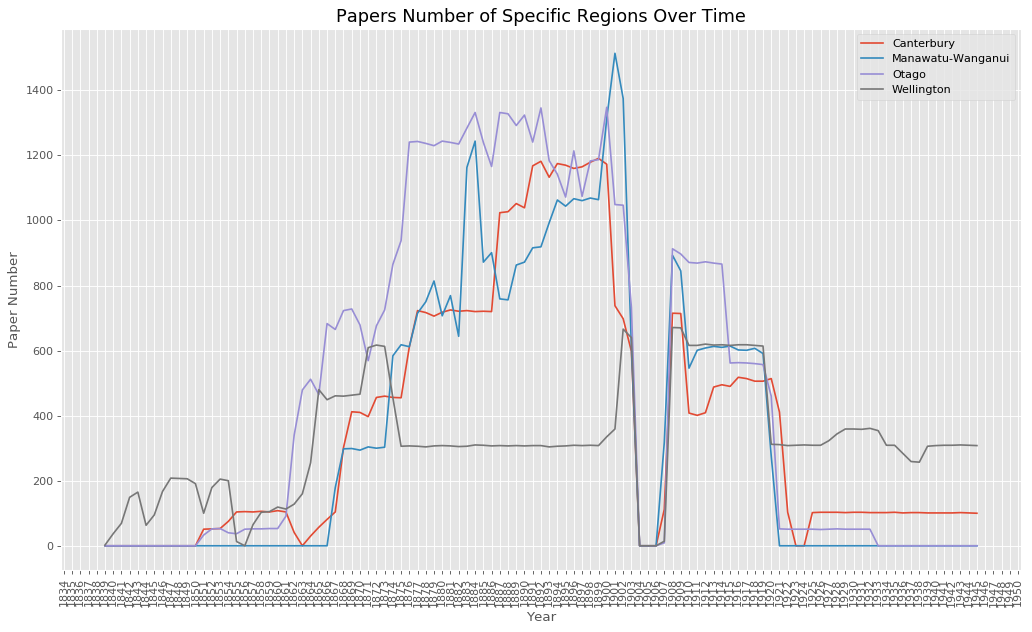

In [22]:
# set regions
list_regions = df_region_count.region[:4].tolist()

# plot
fig, ax = plt.subplots(figsize=(13, 8), dpi=dpi)

year = mdates.YearLocator(month=1)
year_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)

for i, c in enumerate(df_paper_region_year.columns):
    if c in list_regions:
        plt.plot_date(df_paper_region_year.index, df_paper_region_year[df_paper_region_year.columns[i]], '-')
        
plt.xlabel('Year')
plt.ylabel('Paper Number')
plt.xticks(rotation='90')
plt.title("Papers Number of Specific Regions Over Time", fontdict=dict(size=16))
ax.legend()
plt.tight_layout()
plt.show()

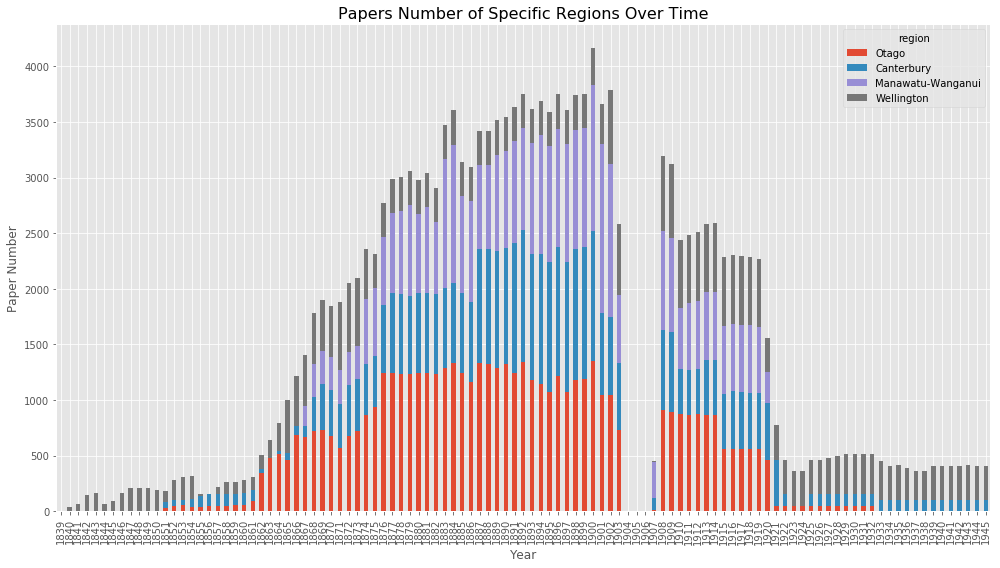

In [23]:
df_paper_region_year_bar.loc[:, list_regions].plot.bar(stacked=True, figsize=(14,8))

plt.xlabel('Year')
plt.ylabel('Paper Number')
plt.xticks(rotation='90')
plt.title("Papers Number of Specific Regions Over Time", fontdict=dict(size=16))
plt.tight_layout()
plt.show()

---

In [24]:
sc.stop()
gc.collect()

32473